# Convolutional Neural Networks

So far we have been treating images as flattened arrays of data. One might argue that such representation is not the best, since by flattening 2D images we are losing all spatial information. Let's now use a different network that exploits spatial information by using convolutional layers.

In [1]:
import matplotlib.pyplot as plt  
%matplotlib inline
from utils import plot_samples, plot_curves
import time

Using TensorFlow backend.


In [2]:
import numpy as np
# force random seed for results to be reproducible
SEED = 4242
np.random.seed(SEED)

## MNIST

In the first part of this session we will use MNIST data to train the network. Using fully connected layers we achieved an accuracy of nearly 0.98 on the test set. Let's see if we can improve this with convolutional layers.

In [3]:
from keras.datasets import mnist
from keras.utils import np_utils

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

img_rows = X_train.shape[1]
img_cols = X_train.shape[2]

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')


nb_classes = 10
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


**Exercise**: Design a model with [convolutional layers](https://keras.io/layers/convolutional/#convolution2d) for MNIST classification.


You may also need to use other layer types:

```python
keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), border_mode='valid')
keras.layers.core.Flatten()
keras.layers.core.Activation()
keras.layers.core.Dropout()
```

Keep things simple: remember that training these models is computationally expensive. Limit the amount of layers and neurons to reduce the number of parameters. More than 100K parameters is not recommended for training in CPU.


**Answer:**

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Convolution2D, MaxPooling2D, Flatten


# number of convolutional filters to use
nb_filters = 8
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3,3)
h_dim = 28
dr_ratio = 0.2

model = Sequential()
# ...
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                        border_mode='same',
                        input_shape=input_shape))

model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(h_dim))
model.add(Activation('relu'))
model.add(Dropout(dr_ratio))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 28, 28, 8)     80          convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 28, 28, 8)     0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 28, 28, 8)     584         activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 28, 28, 8)     0           convolution2d_2[0][0]            
___________________________________________________________________________________________

**Exercise**: The convolutional layer in keras has a parameter ```border_mode```, which can take values of 'valid' (no padding) or 'same' (+padding). What is the impact in the parameters when setting it to  'valid' or 'same', respectively? Why does the number of parameters change?

**Answer:** Adding padding makes the output of the convolution the same size as the input. If no additional pooling layers are added, this makes the output of the layer before the ```Dense``` layer (the one with the highest number of parameters due to dense connectivity) bigger than when we don't add padding, thus increasing the total number of parameters of the network.

Let's train the model. Notice that this procedure is going to take a lot longer than the ones in the previous session. Convolutions are computationally expensive, and even the simplest model takes a long time to train without a GPU.

In [5]:
from keras.optimizers import SGD
lr = 0.01
# For now we will not decrease the learning rate
decay = 0

optim = SGD(lr=lr, decay=decay, momentum=0.9, nesterov=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
54s - loss: 0.3416 - acc: 0.8915 - val_loss: 0.1112 - val_acc: 0.9655
Epoch 2/10
53s - loss: 0.1379 - acc: 0.9583 - val_loss: 0.0735 - val_acc: 0.9773
Epoch 3/10
54s - loss: 0.1051 - acc: 0.9673 - val_loss: 0.0604 - val_acc: 0.9816
Epoch 4/10
53s - loss: 0.0919 - acc: 0.9713 - val_loss: 0.0544 - val_acc: 0.9827
Epoch 5/10
53s - loss: 0.0796 - acc: 0.9756 - val_loss: 0.0523 - val_acc: 0.9830
Epoch 6/10
52s - loss: 0.0723 - acc: 0.9772 - val_loss: 0.0523 - val_acc: 0.9835
Epoch 7/10
53s - loss: 0.0647 - acc: 0.9795 - val_loss: 0.0478 - val_acc: 0.9856
Epoch 8/10
52s - loss: 0.0615 - acc: 0.9807 - val_loss: 0.0481 - val_acc: 0.9844
Epoch 9/10
53s - loss: 0.0576 - acc: 0.9820 - val_loss: 0.0494 - val_acc: 0.9856
Epoch 10/10
53s - loss: 0.0537 - acc: 0.9829 - val_loss: 0.0499 - val_acc: 0.9845
536.7336273193359 seconds.
----------
Loss: 0.049908
Accuracy: 0.984500


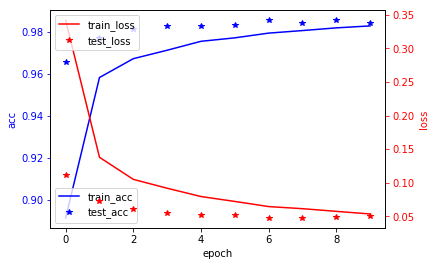

In [6]:
batch_size = 32
nb_epoch = 10

model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])
t = time.time()
# GeForce GTX 980 - 161 seconds 30 epochs bs 128
# GeForce GTX Titan Black - 200 seconds 30 epochs bs 128
history = model.fit(X_train, Y_train,
                batch_size=batch_size, nb_epoch=nb_epoch,
                verbose=2,validation_data=(X_test, Y_test))
print (time.time() - t, "seconds.")

score = model.evaluate(X_test, Y_test, verbose=0)
print ("-"*10)
print ("Loss: %f"%(score[0]))
print ("Accuracy: %f"%(score[1]))
plot_curves(history,nb_epoch)

In [7]:
model.save('../models/mnist_conv.h5')

### While you are waiting...

**Exercise**: Calculate the number of parameters of the new network you just defined.

**Answer:**

In [8]:
krnl = 3
image_channels = 1
conv_filters = 8
pool = 2
im_size = 28
dense_dim = 28
classes = 10


conv1 = (krnl*krnl*image_channels*conv_filters + conv_filters)
conv2 = (krnl*krnl*conv_filters*conv_filters + conv_filters)
dense1 = ((im_size/2)**2)*conv_filters*dense_dim + dense_dim
cls = dense_dim*classes+classes

conv1+conv2+dense1+cls

44886.0

We could probably train this model for a lot longer and results would still improve. Since our time is limited, let's move on for now.

## Transitioning to RGB images: CIFAR 10

At this point we already know how to train a convnet for classification. Let's now switch to a more challenging dataset of colour images: CIFAR 10.

In [9]:
from keras.datasets import cifar10
import numpy as np
np.random.seed(4242)

Let's load the dataset and display some samples:

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


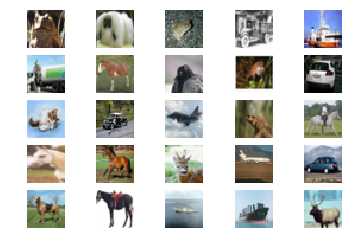

In [10]:
# The data, shuffled and split between train and test sets:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

plot_samples(X_train,5)

We format the data before training:

In [11]:
nb_classes = 10
# Convert class vectors to binary class matrices.
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train.shape
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
input_shape = (img_rows, img_cols,3)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

input_shape

(32, 32, 3)

**Exercise:** Design and train a convnet to classify cifar 10 images. Hint: Images now have 3 channels instead of 1 !

**Answer:**

In [12]:
n_filters = 8
f_size = 3
p_size = 2
dp_ratio = 0.2
dense_dim = 28

model = Sequential()

model.add(Convolution2D(n_filters, f_size, f_size, border_mode='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(n_filters, f_size, f_size, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(p_size, p_size)))
model.add(Flatten())
model.add(Dense(dense_dim))
model.add(Activation('relu'))
model.add(Dropout(dp_ratio))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 32, 32, 8)     224         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
activation_5 (Activation)        (None, 32, 32, 8)     0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 32, 32, 8)     584         activation_5[0][0]               
____________________________________________________________________________________________________
activation_6 (Activation)        (None, 32, 32, 8)     0           convolution2d_4[0][0]            
___________________________________________________________________________________________

In [13]:
nb_epoch=10
lr = 0.01
decay = 1e-6

optim = SGD(lr=lr, decay=decay, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])
t = time.time()

history = model.fit(X_train, Y_train,
                batch_size=batch_size, nb_epoch=nb_epoch,
                verbose=2,validation_data=(X_test, Y_test))

print (time.time() - t, 'seconds.')

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
72s - loss: 1.7244 - acc: 0.3653 - val_loss: 1.5924 - val_acc: 0.4471
Epoch 2/10
72s - loss: 1.4531 - acc: 0.4724 - val_loss: 1.3675 - val_acc: 0.5063
Epoch 3/10
73s - loss: 1.3612 - acc: 0.5090 - val_loss: 1.2606 - val_acc: 0.5481
Epoch 4/10
75s - loss: 1.2907 - acc: 0.5355 - val_loss: 1.1889 - val_acc: 0.5754
Epoch 5/10
72s - loss: 1.2256 - acc: 0.5589 - val_loss: 1.1609 - val_acc: 0.5887
Epoch 6/10
72s - loss: 1.1799 - acc: 0.5764 - val_loss: 1.1431 - val_acc: 0.5898
Epoch 7/10
72s - loss: 1.1363 - acc: 0.5918 - val_loss: 1.1650 - val_acc: 0.5941
Epoch 8/10
71s - loss: 1.0981 - acc: 0.6052 - val_loss: 1.1489 - val_acc: 0.5965
Epoch 9/10
71s - loss: 1.0759 - acc: 0.6131 - val_loss: 1.1420 - val_acc: 0.6056
Epoch 10/10
72s - loss: 1.0480 - acc: 0.6219 - val_loss: 1.1861 - val_acc: 0.5851
728.4339511394501 seconds.


Loss: 1.186060
Accuracy: 0.585100


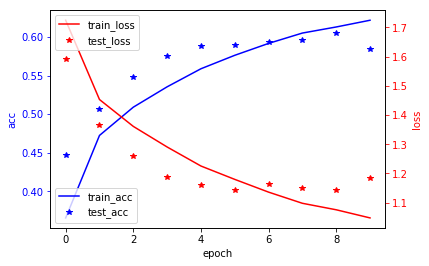

In [14]:
score = model.evaluate(X_test, Y_test, verbose=0)
print ("Loss: %f"%(score[0]))
print ("Accuracy: %f"%(score[1]))
plot_curves(history,nb_epoch)

In [15]:
model.save('../models/cifar10.h5')

**Exercise**: Calculate the number of parameters of the model.

**Answer:**

In [16]:
conv_filters = 8
dense_dim = 28
cls = 10

f_size = 3
conv1 = f_size*f_size*3*conv_filters + conv_filters
conv2 = f_size*f_size*conv_filters*conv_filters + conv_filters
dense = 16*16*conv_filters*dense_dim + dense_dim
cls = dense_dim*cls+cls

conv1+conv2+dense+cls

58470

Final notes: Though there probably won't be enough time to properly train the cifar model until convergence, you can try to finish training at home. Track the training and validation curves to know when to stop training. For the next practical sessions, a fully trained model with CIFAR will be provided.